## This notebook is part of the Spark training delivered by CERN IT
### Regression with spark.ml
Contact: Luca.Canali@cern.ch

This notebook is an implementation of a regression system trained using `spark.ml` to predict house prices.

The data used for this exercise is the "California Housing Prices dataset" from the StatLib repository, originally featured in the following paper: Pace, R. Kelley, and Ronald Barry. "Sparse spatial autoregressions." Statistics & Probability Letters 33.3 (1997): 291-297.
The code and steps we follow in this notebook are inspired by the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, Aurelien Geron, 2nd Edition".


Run this notebook from Jupyter with Python kernel
- When using on CERN SWAN, do not attach the notebook to a Spark cluster, but rather run locally on the SWAN container
- If running this outside CERN SWAN, plese make sure to tha PySpark installed: `pip install pyspark`

## Create the Spark session and read the data

In [ ]:
#
# Local mode: run this when using CERN SWAN not connected to a cluster 
#             or run it on a private Jupyter notebook instance
#             Dependency: PySpark (use SWAN or pip install pyspark)
#

from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("ML HandsOn Regression") \
        .config("spark.driver.memory","4g") \
        .config("spark.ui.showConsoleProgress", "false") \
        .getOrCreate()

In [2]:
spark

In [3]:
# Local mode: read the data locally from the cloned repo
df = (spark.read
      .format("csv")
      .option("header","true")
      .option("inferschema","true")
      .load("../data/housing.csv.gz")
     )


## Split data into a training and test datasets

In [4]:
train, test = df.randomSplit([0.8, 0.2], 4242)

# cache the training dataset
train.cache().count()

16526

## Basic data exploration

In [5]:
train.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [6]:
# The dataset reports housing prices in California from 1990s
train.limit(10).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-124.35,40.54,52.0,1820.0,300.0,806.0,270.0,3.0147,94600.0,NEAR OCEAN
1,-124.30,41.80,19.0,2672.0,552.0,1298.0,478.0,1.9797,85800.0,NEAR OCEAN
2,-124.30,41.84,17.0,2677.0,531.0,1244.0,456.0,3.0313,103600.0,NEAR OCEAN
3,-124.27,40.69,36.0,2349.0,528.0,1194.0,465.0,2.5179,79000.0,NEAR OCEAN
4,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571,111400.0,NEAR OCEAN
5,-124.25,40.28,32.0,1430.0,419.0,434.0,187.0,1.9417,76100.0,NEAR OCEAN
6,-124.23,40.54,52.0,2694.0,453.0,1152.0,435.0,3.0806,106700.0,NEAR OCEAN
7,-124.23,41.75,11.0,3159.0,616.0,1343.0,479.0,2.4805,73200.0,NEAR OCEAN
8,-124.22,41.73,28.0,3003.0,699.0,1530.0,653.0,1.7038,78300.0,NEAR OCEAN
9,-124.21,40.75,32.0,1218.0,331.0,620.0,268.0,1.6528,58100.0,NEAR OCEAN


In [7]:
train.createOrReplaceTempView("train")
spark.sql("select ocean_proximity, count(*) from train group by ocean_proximity").show()

+---------------+--------+
|ocean_proximity|count(1)|
+---------------+--------+
|         ISLAND|       3|
|     NEAR OCEAN|    2133|
|       NEAR BAY|    1860|
|      <1H OCEAN|    7298|
|         INLAND|    5232|
+---------------+--------+



In [8]:
# the are some missing data in the total_bedrooms feature (i.e. there are null values)

spark.sql("select count(*) from train where total_bedrooms is null").show()

+--------+
|count(1)|
+--------+
|     175|
+--------+



## Feature preparation

In [9]:
from pyspark.ml.feature import StringIndexer,OneHotEncoder,VectorIndexer,Imputer,VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

In [10]:
# Transform ocean_proximity feature in a one-hot encoded feature 
ocean_index = StringIndexer(inputCol="ocean_proximity",outputCol="indexed_ocean_proximity")
ocean_onehot = OneHotEncoder(inputCol="indexed_ocean_proximity",outputCol="oh_ocean_proximity",dropLast=False)

# Add missing data to the total_bedrooms feature, by using estimation.
imputer_tot_br = Imputer(strategy='median',inputCols=["total_bedrooms"],outputCols=["total_bedrooms_filled"])

features = ["longitude", "latitude", "housing_median_age", 
            "total_rooms", "population", "households", 
            "median_income", "total_bedrooms_filled"]
                         

### Build a pipeline, bundling the feature preparation steps

In [11]:
feature_preparation_pipeline = Pipeline(stages=[ocean_index,ocean_onehot,imputer_tot_br])

In [12]:
# fit the feature preparation pipeline with trinaing data and show the 
feature_preparation_transformer = feature_preparation_pipeline.fit(train)

# show a sample of data after feature preparation
feature_preparation_transformer.transform(train).limit(10).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,indexed_ocean_proximity,oh_ocean_proximity,total_bedrooms_filled
0,-124.35,40.54,52.0,1820.0,300.0,806.0,270.0,3.0147,94600.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)",300.0
1,-124.30,41.80,19.0,2672.0,552.0,1298.0,478.0,1.9797,85800.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)",552.0
2,-124.30,41.84,17.0,2677.0,531.0,1244.0,456.0,3.0313,103600.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)",531.0
3,-124.27,40.69,36.0,2349.0,528.0,1194.0,465.0,2.5179,79000.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)",528.0
4,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571,111400.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)",394.0
5,-124.25,40.28,32.0,1430.0,419.0,434.0,187.0,1.9417,76100.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)",419.0
6,-124.23,40.54,52.0,2694.0,453.0,1152.0,435.0,3.0806,106700.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)",453.0
7,-124.23,41.75,11.0,3159.0,616.0,1343.0,479.0,2.4805,73200.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)",616.0
8,-124.22,41.73,28.0,3003.0,699.0,1530.0,653.0,1.7038,78300.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)",699.0
9,-124.21,40.75,32.0,1218.0,331.0,620.0,268.0,1.6528,58100.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)",331.0


### Further data preparation

Vector assembler puts all data in a vector column. This step is required by the Spark ML algorithms.  
Standard scaler is a data preparation step. StandardScaler follows Standard Normal Distribution (SND). Therefore, it makes mean = 0 and scales the data to unit variance.  

In [13]:
assembler = VectorAssembler(inputCols=features, outputCol="unscaled_features")

std_scaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

In [14]:
full_feature_preparation_pipeline = Pipeline(stages=[feature_preparation_pipeline,assembler,std_scaler])

In [15]:
# this shows the results of data scaling
full_feature_preparation_transformer = full_feature_preparation_pipeline.fit(train)

full_feature_preparation_transformer.transform(train).select("unscaled_features","features").limit(10).toPandas()

,unscaled_features,features
0,"[-124.35, 40.54, 52.0, 1820.0, 806.0, 270.0, 3...","[-62.03326688689804, 18.957877035296093, 4.137..."
1,"[-124.3, 41.8, 19.0, 2672.0, 1298.0, 478.0, 1....","[-62.00832387648916, 19.547095709802086, 1.511..."
2,"[-124.3, 41.84, 17.0, 2677.0, 1244.0, 456.0, 3...","[-62.00832387648916, 19.56580106454831, 1.3527..."
3,"[-124.27, 40.69, 36.0, 2349.0, 1194.0, 465.0, ...","[-61.99335807024382, 19.028022115594425, 2.864..."
4,"[-124.26, 40.58, 52.0, 2217.0, 907.0, 369.0, 2...","[-61.988369468162055, 18.976582390042314, 4.13..."
5,"[-124.25, 40.28, 32.0, 1430.0, 434.0, 187.0, 1...","[-61.983380866080275, 18.83629222944565, 2.546..."
6,"[-124.23, 40.54, 52.0, 2694.0, 1152.0, 435.0, ...","[-61.97340366191672, 18.957877035296093, 4.137..."
7,"[-124.23, 41.75, 11.0, 3159.0, 1343.0, 479.0, ...","[-61.97340366191672, 19.52371401636931, 0.8753..."
8,"[-124.22, 41.73, 28.0, 3003.0, 1530.0, 653.0, ...","[-61.96841505983494, 19.5143613389962, 2.22808..."
9,"[-124.21, 40.75, 32.0, 1218.0, 620.0, 268.0, 1...","[-61.96342645775316, 19.056080147713757, 2.546..."


## Define the model and assemble a pipeline

In [16]:
from pyspark.ml.regression import GBTRegressor

regressor = GBTRegressor(labelCol="median_house_value", maxIter=40)

pipeline = Pipeline(stages=[full_feature_preparation_pipeline, regressor])
# this is equivalent to
# pipeline = Pipeline(stages=[ocean_index, ocean_onehot, imputer_tot_br, assembler, std_scaler, regressor])


## Fit the model using the training dataset

In [17]:
# model training 
# this uses the pipeline built above
# the pipeline puts together transformers and the model and is an estimator
# we are going to fit it to the training data

model = pipeline.fit(train)

In [ ]:
# the trained model can be saved on the filesystem

model.save("myTrainedModel")

## Evaluate the model performance on the test dataset  by computing RMSE

In [19]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test)
dt_evaluator = RegressionEvaluator(
    labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 54528.9


2022-09-29 21:02:23,307 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
2022-09-29 21:02:23,320 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


## Correlation Matrix
The correlation matrix demonstrates the relationship between features.  
Correlation ranges from -1 to +1. Values closer to zero means there is no linear trend between the two variables.  
It is often displayed using a heatmap.

In [20]:
from pyspark.ml.stat import Correlation

matrix = Correlation.corr(full_feature_preparation_transformer.transform(train).select('features'), 'features')
matrix_np = matrix.collect()[0]["pearson({})".format('features')].values

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


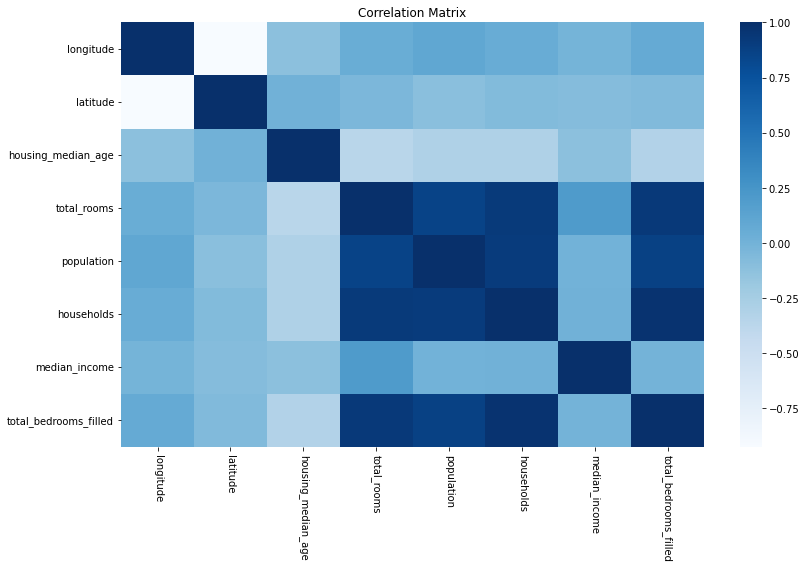

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt 

matrix_np = matrix_np.reshape(8,8)

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(matrix_np, cmap="Blues")
ax.xaxis.set_ticklabels(features, rotation=270)
ax.yaxis.set_ticklabels(features, rotation=0)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

## An example of cross validation and grid search 

In [22]:
## This crossvalidation step takes several minutes, depending on the available cores

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator


paramGrid = ParamGridBuilder()\
    .addGrid(regressor.maxIter, [100,50]) \
    .baseOn({regressor.labelCol: "median_house_value"})\
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="median_house_value"),
                          numFolds=4)
cvModel=crossval.fit(train)

In [23]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = cvModel.transform(test)
dt_evaluator = RegressionEvaluator(
    labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 51711.3


In [24]:
spark.stop()